In [82]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_3d

Equation:

$$
0 = \max_{e} \min_{h_2} b\left[\delta \eta \log e - \delta(1-\eta)y z_2 -\frac{\gamma_2}{2}\beta_f^2 z_2^2y^2  + \xi_m\frac{(h_2)^2}{2}\right] -\ell e + \frac{\partial \phi}{\partial y}(y, b, z_2;\ell) e + \left[\frac{\partial^2 \phi}{\partial y^2}(y,b, z_2;\ell)\right] \epsilon - \frac{\partial \phi}{\partial b}(y, b, z_2;\ell) \delta b + \left[\frac{\partial \phi}{\partial z_2}(y, b, z_2;\ell)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y,b, z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, b, z_2;\ell)\right]\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC of $e$ gives :

$$
e^* = \frac{b \delta \eta}{\ell - \frac{\partial \phi}{\partial y}(y, b, z_2; \ell)}
$$

In [200]:
def false_transient_one_iteration(stateSpace, A, B_z, B_b, B_y, C_zz, C_bb, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, y_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras
    β_f = 1.86/1000
    γ_2 = 2*0.0022
    eps = 1e-4
    
    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, b_mat, y_mat) = np.meshgrid(z_grid, b_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.
    
    e_old = 0. # smooth
    h_old = 0. # smooth
    
    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_3d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_3d(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives_3d(v0, 1, 1, Δ_b)
        v0_dy = compute_derivatives_3d(v0, 2, 1, Δ_y)
        v0_dyy = compute_derivatives_3d(v0, 2, 2, Δ_y)

        e = b_mat*δ*η / (ℓ-v0_dy)
        e[e<=0] = 1e-5
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)
        
        e = e*0.5 + e_old*0.5 # smooth
        h = h*0.5 + h_old*0.5 # smooth
        
        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        C_yy = np.ones_like(z_mat) * eps
        D = b_mat*(δ*η*np.log(e) - δ*(1-η)*y_mat*z_mat - γ_2*β_f**2*z_mat**2*y_mat**2/2 + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, B_y, C_zz, C_bb, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + B_y*v0_dy + C_zz*v0_dzz + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        
        e_old = e.copy() # smooth
        h_old = h.copy() # smooth
        
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0

In [201]:
# Model parameters
median = 1.86/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.86/1000.
ρ = 0.99
σ_2 = np.sqrt((.42/1000.)**2*2*ρ/μ_2)

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

# Grid setting
n_z = 20
z_min = 1e-5
z_max = 0.004
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 20
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

n_y = 20
y_min = 1e-2
y_max = 2000.
y_grid = np.linspace(y_min, y_max, n_y)

# ℓ setting
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [202]:
# ψs = []
# ψs_next = []
# ψ_guess = np.load('phi_guess.npy')

# for i, ℓ in enumerate(np.exp(log_ell_grid)):
#     print(i)
#     max_iter = 2000
#     ψ = false_transient(z_grid, b_grid, y_grid, ℓ, model_paras=model_paras, v0=ψ_guess, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψ_next = false_transient(z_grid, b_grid, y_grid, ℓ+ℓ_step, model_paras=model_paras, v0=ψ_guess, ϵ=.5, tol=1e-8, max_iter=max_iter)
#     ψs.append(ψ)
#     ψs_next.append(ψ_next)

In [203]:
ψ = false_transient(z_grid, b_grid, y_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.1, tol=1e-8, max_iter=40)

Iteration 1: LHS Error: 0.07296797204480052; RHS Error 0.07671325872056327
Iteration 2: LHS Error: 0.07027981256155824; RHS Error 0.07329336571588554
Iteration 3: LHS Error: 0.06871079631805291; RHS Error 0.07096750011412882
Iteration 4: LHS Error: 0.06798607680736882; RHS Error 0.06954371422583758
Iteration 5: LHS Error: 0.06791160083667455; RHS Error 0.06884333087637277
Iteration 6: LHS Error: 0.06837039229659454; RHS Error 0.06874185540763367
Iteration 7: LHS Error: 0.0692963567342679; RHS Error 0.06915853455564103
Iteration 8: LHS Error: 0.0706559084686597; RHS Error 0.07004357484156631
Iteration 9: LHS Error: 0.07243788453489698; RHS Error 0.07136997509307917
Iteration 10: LHS Error: 0.0746489968108828; RHS Error 0.07312891213132094
Iteration 11: LHS Error: 0.07731236374832945; RHS Error 0.07532785466730806
Iteration 12: LHS Error: 0.08046810166026708; RHS Error 0.07799030365467334
Iteration 13: LHS Error: 0.08417563164242456; RHS Error 0.08115695987942367
Iteration 14: LHS Error:

In [ ]:
# np.save('phi_guess.npy', ψ)

Text(0, 0.5, 'ϕ')

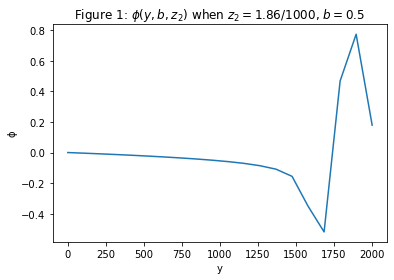

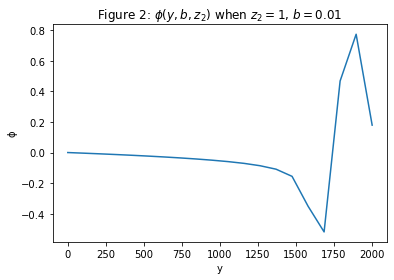

In [204]:
# fig = go.Figure(data=[go.Surface(z=ψ[10,:,:])])

# fig.update_layout(title='Mt Bruno Elevation', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

# fig.show()

plt.figure()
plt.plot(y_grid, ψ[10,10,:])
plt.title(r'Figure 1: $\phi(y,b,z_2)$ when $z_2=1.86/1000$, $b=0.5$ ')
plt.xlabel('y')
plt.ylabel('ϕ')
plt.savefig('fig_1.pdf')

plt.figure()
plt.plot(y_grid, ψ[10,10,:])
plt.title(r'Figure 2: $\phi(y,b,z_2)$ when $z_2=1.$, $b=0.01$ ')
plt.xlabel('y')
plt.ylabel('ϕ')
# plt.savefig('fig_2.pdf')

In [ ]:
plt.figure()
plt.plot(y_grid, ψ[10,20,:])
plt.title(r'Figure 1: $\phi(y,b,z_2)$ when $z_2=1.$, $b=0.5$ ')
plt.xlabel('y')
plt.ylabel('ϕ')
plt.savefig('fig_3.pdf')

In [ ]:
from numba import njit
@njit
def simulate_z(μ, ρ, σ, T):
    Ws = np.random.normal(0., 1., T)
    Zs = np.zeros(T)
    Zs[0] = μ
    for i in range(1, T):
        Zs[i] = Zs[i-1] - ρ*(Zs[i-1]-μ) + np.sqrt(Zs[i-1])*σ*Ws[i]
    return Zs

In [ ]:
res = simulate_z(μ_2, .99, 0.004, 1_000_000)
plt.hist(res, bins=2000, label=r'Var(Z) = .004')
plt.title(r'Figure 1: $\mu_2 = 1$, $\rho = .99$, $\sigma_2 = .004$')
plt.legend()
plt.savefig('fig_1.pdf')
plt.show()

In [ ]:
np.std(res)*5

In [ ]:
np.percentile(res, 1)

In [ ]:
res = simulate_z(μ_2, 1e-8, 2.97e-5, 100_000_000)

In [ ]:
plt.hist(res, bins=2000, label=r'Var(Z) = 0.21')
plt.title(r'Figure 2: $\mu_2 = 1$, $\rho = 10^{-8}$, $\sigma_2 = 3*10^{-5}$')
plt.legend()
plt.savefig('fig_2.pdf')
plt.show()